In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np

In [3]:
## Import standard packages
from xgboost import XGBRegressor
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep

In [4]:
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("ticker_overview")
market.disconnect()

## Retrieve previously calculated Macro Projections
fred.connect()
sp500 = p.lower_column(fred.retrieve("sp500_projections").rename(columns={"prediction":"sp500_prediction"}))
sp500 = p.utc_date(sp500)
interest_rates = p.lower_column(fred.retrieve("market_yield").rename(columns={"value":"rf"}))
interest_rates = p.utc_date(interest_rates)
interest_rates["rf"] = interest_rates["rf"].replace(".",0)
interest_rates["rf"] = [float(x) / 100 for x in interest_rates["rf"]]
fred.disconnect()
macro = sp500.merge(interest_rates,on="date",how="left")
macro = p.utc_date(macro)

In [6]:
factors = ["assets","liabilities","reference_price"]

In [8]:
market.connect()
sec.connect()
factors_df = []
rolling_window = 100
skips = 1
for ticker in tqdm(index["ticker"][::skips]):
    try:
        cik = int(index[index["ticker"]==ticker].iloc[0]["cik"])
        price = market.query("prices",{"ticker":ticker})
        filings = sec.query("filings",{"cik":cik})
        if price.index.size > 0 and filings.index.size > 0:
            price = p.utc_date(price)
            price = p.additional_date_columns(price)
            price.sort_values("date",inplace=True)
            price = Metric.STANDARD_DEV.calculate(price,timeframe=rolling_window)
            filings = p.utc_date(filings)
            filings = p.lower_column(filings)
            filings = p.additional_date_columns(filings)
            ticker_factors = filings.drop(["date","month","week","cik"],axis=1).groupby(["year","quarter"]).mean().reset_index()
            price = price.drop(["date","ticker"],axis=1).groupby(["year","quarter"]).mean().reset_index()
            ticker_factors = ticker_factors.merge(price,on=["year","quarter"],how="left")
            ticker_factors = ticker_factors.ffill()
            ticker_factors["year"] = ticker_factors["year"] + 1
            if ticker_factors.index.size > 0:
                ticker_factors["ticker"] = ticker
                ticker_factors["reference_price"] = ticker_factors["adjclose"].shift(1)
                ticker_factors["y"] = ticker_factors["adjclose"].shift(-1)
                factors_df.append(ticker_factors[["year","quarter","ticker","adjclose","standard_dev","y"]+factors])
    except Exception as e:
        print(ticker,str(e))
        continue
sec.disconnect()
market.disconnect()
factors_df = pd.concat(factors_df).sort_values(["year","quarter"])

 24%|████████████████████████████████████████▉                                                                                                                               | 1038/4266 [00:26<01:29, 35.92it/s]

GBFH cannot convert float NaN to integer


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 3374/4266 [01:31<00:21, 40.81it/s]

TOWN cannot convert float NaN to integer


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4266/4266 [01:53<00:00, 37.47it/s]


In [9]:
model_start = 2018
model_end = 2024
backtest_end = 2026
model = XGBRegressor(booster="gbtree",random_state=42)
factors_df = factors_df.dropna(subset=factors)
training_data = factors_df[(factors_df["year"]>=model_start) & (factors_df["year"]<model_end)].dropna()
sim = factors_df[(factors_df["year"]>=model_end-1) & (factors_df["year"]<backtest_end)].dropna(subset=factors)
model.fit(training_data[factors],training_data["y"])
sim["prediction"] = model.predict(sim[factors])
sim = sim[["ticker","year","quarter","prediction"]]

In [10]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"][::skips]):
    try:
        price = p.utc_date(market.query("prices",{"ticker":ticker}))
        price = p.additional_date_columns(price)
        dividends = market.query("dividends",{"ticker":ticker})
        if dividends.index.size > 0:
            dividends = p.utc_date(dividends)
            price = price.merge(dividends,on=["date","ticker"])
            price["dividend"] = price["rate"].ffill().fillna(0)
        else:
            price["dividend"] = 0
        price.sort_values("date",inplace=True)
        price = price.merge(sim,on=["year","quarter","ticker"],how="left")
        price = p.utc_date(price)
        price = price.merge(macro,on="date",how="left")
        price["factor"] = price["prediction"] / price["adjclose"] - 1
        price = SingleIndexCAPM.apply(price)
        for member in Metric:
            price = member.calculate(price,timeframe=rolling_window)
        for member in RiskType:
            price = member.apply(price)
        prices.append(price)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

  0%|▏                                                                                                                                                                          | 6/4266 [00:00<02:31, 28.07it/s]

'date'


  8%|█████████████▋                                                                                                                                                           | 344/4266 [00:13<02:26, 26.81it/s]

'date'


 12%|███████████████████▌                                                                                                                                                     | 495/4266 [00:18<01:56, 32.45it/s]

'date'


 14%|████████████████████████▍                                                                                                                                                | 616/4266 [00:23<02:01, 30.05it/s]

'date'


 19%|███████████████████████████████▌                                                                                                                                         | 796/4266 [00:30<01:58, 29.24it/s]

index 0 is out of bounds for axis 0 with size 0


 21%|██████████████████████████████████▋                                                                                                                                      | 877/4266 [00:33<01:55, 29.36it/s]

'date'


 22%|████████████████████████████████████▎                                                                                                                                    | 918/4266 [00:34<01:56, 28.85it/s]

'date'


 31%|████████████████████████████████████████████████████▊                                                                                                                   | 1340/4266 [00:51<01:39, 29.50it/s]

'date'


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 2433/4266 [01:34<01:02, 29.17it/s]

'date'


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 2857/4266 [01:51<01:16, 18.54it/s]

index 0 is out of bounds for axis 0 with size 0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 2977/4266 [01:55<00:49, 26.18it/s]

'date'


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2998/4266 [01:56<00:42, 29.67it/s]

'date'


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3111/4266 [02:00<00:39, 29.10it/s]

'date'


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 3325/4266 [02:09<00:33, 27.85it/s]

'date'


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 3374/4266 [02:12<00:31, 28.05it/s]

'date'


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 3411/4266 [02:13<00:30, 28.04it/s]

'date'


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 3436/4266 [02:14<00:29, 28.37it/s]

'date'


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 3710/4266 [02:24<00:18, 30.73it/s]

'date'


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 3725/4266 [02:25<00:16, 33.07it/s]

'date'
'date'


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 3783/4266 [02:27<00:14, 34.15it/s]

'date'
'date'


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 4160/4266 [02:42<00:03, 29.98it/s]

'date'


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 4230/4266 [02:44<00:01, 26.44it/s]

'date'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4266/4266 [02:46<00:00, 25.65it/s]


In [11]:
sim = pd.concat(prices)

In [12]:
## getting names
simulation = pd.concat(prices)
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)].dropna(subset="factor")
simulation.sort_values("date", inplace=True)
simulation.columns

Index(['date', 'adjclose', 'high', 'low', 'volume', 'ticker', 'year', 'month',
       'quarter', 'week', 'day', 'rate', 'dividend', 'realtime_start',
       'realtime_end', 'rf', 'factor', 'risk', 'sigma', 'reference_price',
       'reference_volume', 'reference_high', 'reference_low', 'average_return',
       'standard_dev', 'rolling_dollar_volume', 'simple_moving_average',
       'drawdown', 'distance', 'next_close', 'coefficient_of_variation'],
      dtype='object')

In [13]:
len(simulation["ticker"].unique())

1966

In [14]:
portfolios = PortfolioSelection.generate_possible_portfolios(
                                    ranking_metrics=["factor"],
                                    group_percentages=[0.01],
                                    num_of_groups=[10],
                                    max_prices=[10000],
                                    min_prices=[0],
                                    stoplosses=[1],
                                    rolling_windows=[100]
                                )
portfolios = [
    x for x in portfolios if x.position_type.label == "long" 
                and x.max_price > x.min_price 
                and x.timeframe.value == "quarter"
]
print(len(portfolios))

42


In [15]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [16]:
run = True
if run:
    analysises = []
    for portfolio in tqdm(portfolios):
        try:
            trades = portfolio.trades(simulation.copy())
            performance = portfolio.portfolio(trades.copy(),benchmark.copy())
            metrics = KPI.performance(trades,performance)
            results = {**portfolio.to_dict(),**metrics.copy()}
            results["portfolio"] = portfolio
            analysises.append(results)
        except Exception as e:
            print(str(e))
            continue

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:18<00:00,  2.25it/s]


In [17]:
a = pd.DataFrame(analysises)

In [18]:
a["color"] = ["blue" if "top" in x  else "red" if "bottom" in x else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

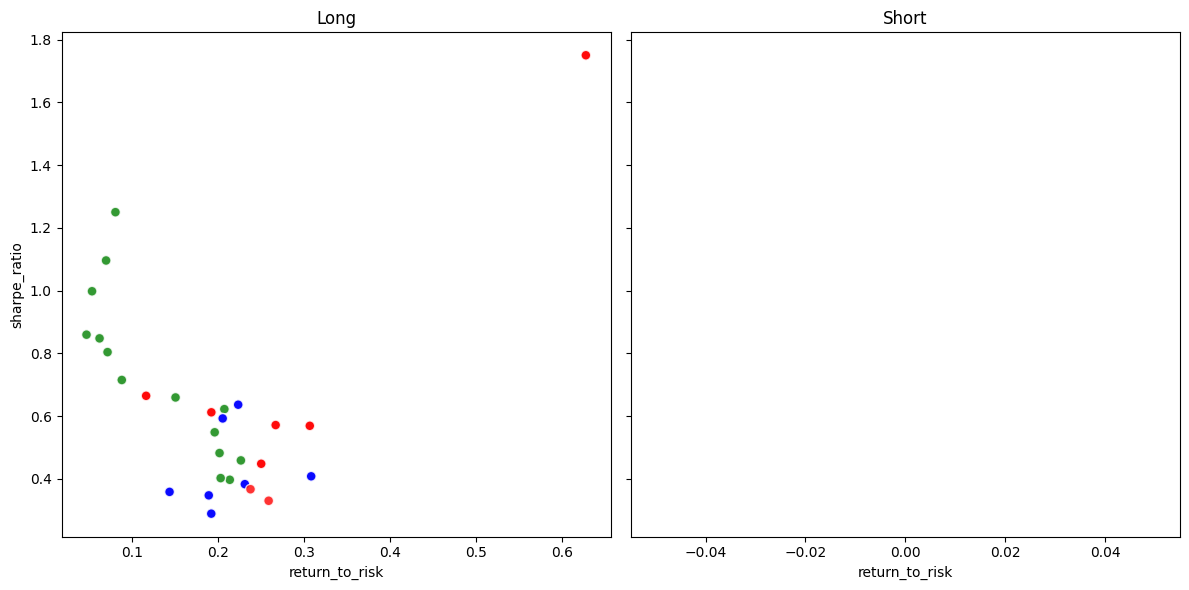

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        s=50,
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [20]:
a.drop(["date","position_type","timeframe","ranking_metric","allocation_type","risk_type","selection_percentage","stoploss","num_of_groups"],axis=1).sort_values("pnl",ascending=False).head(20)

,grouping_type,selection_type,max_price,min_price,rolling_window,pnl,raw_pnl,downside,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,color,return_to_risk
5,STANDARD_DEV,bottom_blacklist,10000,0,100,1.750250,1.750250,0.677827,2.789501,0.627442,2.327044,0.649919,0.38,1.287227,0.844351,<financial_common.portfolio_management.portfol...,red,2.789501
2,STANDARD_DEV,bottom,10000,0,100,1.750250,1.750250,0.677827,2.789501,0.627442,2.327044,0.649919,0.38,1.287227,0.844351,<financial_common.portfolio_management.portfol...,red,2.789501
27,DRAWDOWN,long_short,10000,0,100,1.249975,1.245195,0.992359,15.501632,0.080635,1.321570,0.722993,0.54,1.046224,0.365928,<financial_common.portfolio_management.portfol...,green,15.501632
39,DIVIDEND,long_short,10000,0,100,1.095925,1.128270,0.873951,15.711226,0.069754,1.455281,0.543748,0.53,1.026860,-1.785468,<financial_common.portfolio_management.portfol...,green,15.711226
9,AVERAGE_RETURN,long_short,10000,0,100,0.997838,1.100950,0.918860,18.680657,0.053416,1.345212,0.657935,0.50,1.001573,-4.167905,<financial_common.portfolio_management.portfol...,green,18.680657
15,ROLLING_DOLLAR_VOLUME,long_short,10000,0,100,0.859355,0.879750,0.899246,18.281155,0.047008,1.431711,0.581131,0.46,0.972398,-7.682022,<financial_common.portfolio_management.portfol...,green,18.281155
33,DISTANCE,long_short,10000,0,100,0.847604,0.887334,0.797050,13.632361,0.062176,1.410603,0.573078,0.48,0.975090,-5.996928,<financial_common.portfolio_management.portfol...,green,13.632361
21,SIMPLE_MOVING_AVERAGE,long_short,10000,0,100,0.803760,0.839499,0.853197,11.246081,0.071470,1.468274,0.543897,0.45,0.959867,-5.830523,<financial_common.portfolio_management.portfol...,green,11.246081
3,STANDARD_DEV,long_short,10000,0,100,0.714877,0.719783,0.835058,8.119910,0.088040,1.318264,0.557846,0.50,0.938055,-5.742752,<financial_common.portfolio_management.portfol...,green,8.119910
8,AVERAGE_RETURN,bottom,10000,0,100,0.664432,0.664432,0.735003,5.713179,0.116298,1.468702,0.631806,0.36,0.933089,-4.781127,<financial_common.portfolio_management.portfol...,red,5.713179


In [21]:
top = a.sort_values("pnl",ascending=False).head(1).to_dict("records")[0]
top

{'ranking_metric': 'factor',
 'timeframe': 'QUARTER',
 'position_type': 'long',
 'grouping_type': 'STANDARD_DEV',
 'selection_type': 'bottom_blacklist',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 0.01,
 'stoploss': 1,
 'num_of_groups': 10,
 'max_price': 10000,
 'min_price': 0,
 'rolling_window': 100,
 'date': Timestamp('2025-03-20 00:00:00+0000', tz='UTC'),
 'pnl': 1.7502500369771634,
 'raw_pnl': 1.7502500369771634,
 'downside': 0.6778266695278463,
 'coefficient_of_variation': 2.789500918160384,
 'portfolio_std': 0.6274420006756677,
 'average_gain': 2.3270438922456878,
 'average_loss': 0.6499192316189817,
 'win_loss_ratio': 0.38,
 'weekly_return': 1.28722660265713,
 'sharpe_ratio': 0.8443509331795755,
 'portfolio': <financial_common.portfolio_management.portfolio.Portfolio at 0x2828b45fe50>,
 'color': 'red',
 'return_to_risk': 2.789500918160384}

In [22]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy())
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

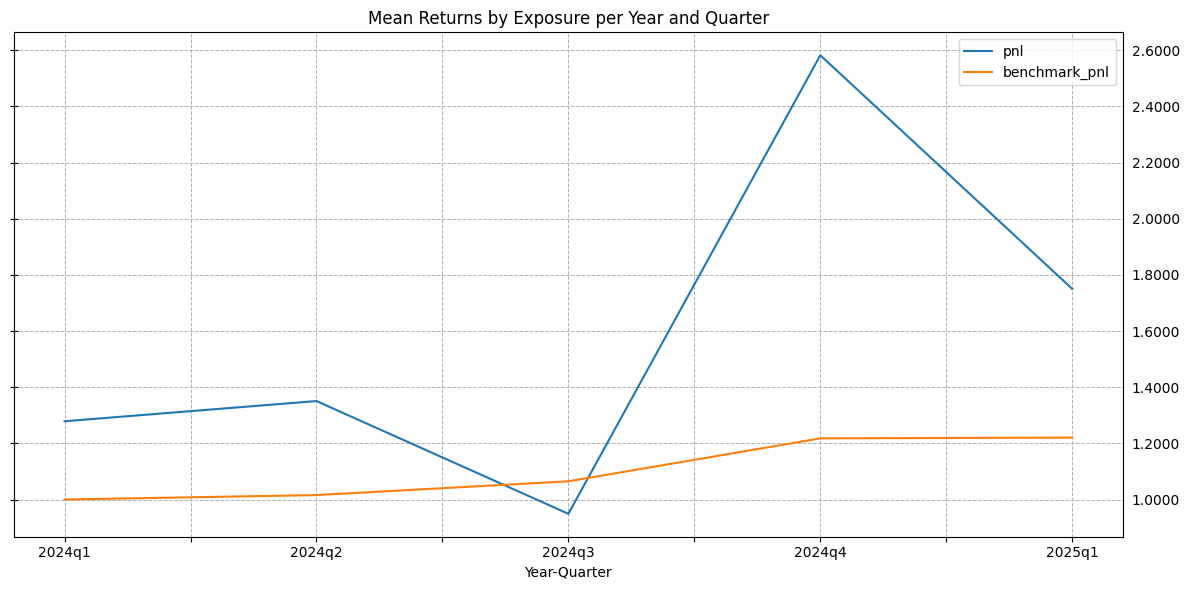

In [23]:
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
ax = portfolio[["Year-Quarter","pnl","benchmark_pnl"]].set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [24]:
portfolio.tail()

,index,year,quarter,date,weighted_return,return,pnl,raw_pnl,benchmark,benchmark_pnl,month,week,day,Year-Quarter
0,0,2024,1,2024-03-28 00:00:00+00:00,1.278675,1.278675,1.278675,1.278675,194.54,1.000000,3,13,88,2024q1
1,1,2024,2,2024-06-28 00:00:00+00:00,1.056256,1.056256,1.350607,1.350607,197.60,1.015729,6,26,180,2024q2
2,2,2024,3,2024-09-30 00:00:00+00:00,0.702712,0.702712,0.949088,0.949088,207.16,1.064871,9,40,274,2024q3
3,3,2024,4,2024-12-31 00:00:00+00:00,2.720664,2.720664,2.582150,2.582150,236.90,1.217744,12,1,366,2024q4
4,4,2025,1,2025-03-20 00:00:00+00:00,0.677827,0.677827,1.750250,1.750250,237.43,1.220469,3,12,79,2025q1


In [25]:
trades[["ticker","return"]].groupby("ticker").mean().sort_values("return",ascending=False).tail(20)

,return
ticker,
OMEX,0.824675
CLDI,0.822860
UNCY,0.819031
DVLT,0.758112
ERNA,0.733333
SBFM,0.712460
AMZE,0.692775
BNZI,0.690323
OTRK,0.689362
